In [13]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, decimate

In [14]:
# ===== SESSION SELECTION =====
SESSION = "a3"         # animal id
STIM = "brush_contra"  # stim type
# =============================


# Load table (prefer local override if present)
table_path = Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep=',')  # your CSV is comma-delimited


# Select row by session + stim
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")


row = row.iloc[0]


# Extract paths and metadata
phy_dir = Path(row['phy_dir']) if pd.notna(row['phy_dir']) and row['phy_dir'].strip() else None
lfp_dir  = Path(row['lfp_dir']) if pd.notna(row['lfp_dir']) and row['lfp_dir'].strip() else None
age = str(row['age']).strip() if pd.notna(row['age']) else "unknown"
notes = str(row['notes']).strip() if pd.notna(row['notes']) else ""


# Anatomy bands
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])


# Optional: mid-depths for LFP channel picking
s1_mid_um  = (S1_upper_um + S1_lower_um) / 2.0
vpl_mid_um = (VPL_upper_um + VPL_lower_um) / 2.0


# Sanity check
if phy_dir is None or not phy_dir.exists():
    print(f"⚠️ Warning: phy_dir not found or empty for {SESSION}/{STIM}. Check paths or notes: '{notes}'")
if lfp_dir is None or not lfp_dir.exists():
    print(f"⚠️ Warning: lfp_dir not found or empty for {SESSION}/{STIM}. Check paths.")


print(f"Loaded: {SESSION} / {STIM} (age: {age})")
print(f"Notes: {notes}")
print(f"phy_dir: {phy_dir}")
print(f"lfp_dir:  {lfp_dir}")


Loaded: a3 / brush_contra (age: adult)
Notes: Sparse
phy_dir: C:\Users\Ben\Desktop\Contra Brush\A3
lfp_dir:  E:\Neurpixels_Sally\practice3_SZMB_brush_final_2024-11-21_15-47-33\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-LFP


In [17]:
# Parameters
# Parameters
t0, twin = 0.0, 30.0  # Time window in seconds
max_ch = None   # set to an int (e.g., 192) to cap plotted channels
bp_lo, bp_hi = 1, 300
gain = 10     # LFP gain per channel (adjust as needed)


✓ Saved: results\figures\a3_brush_contra_allchannel_lfp_27.8s.png


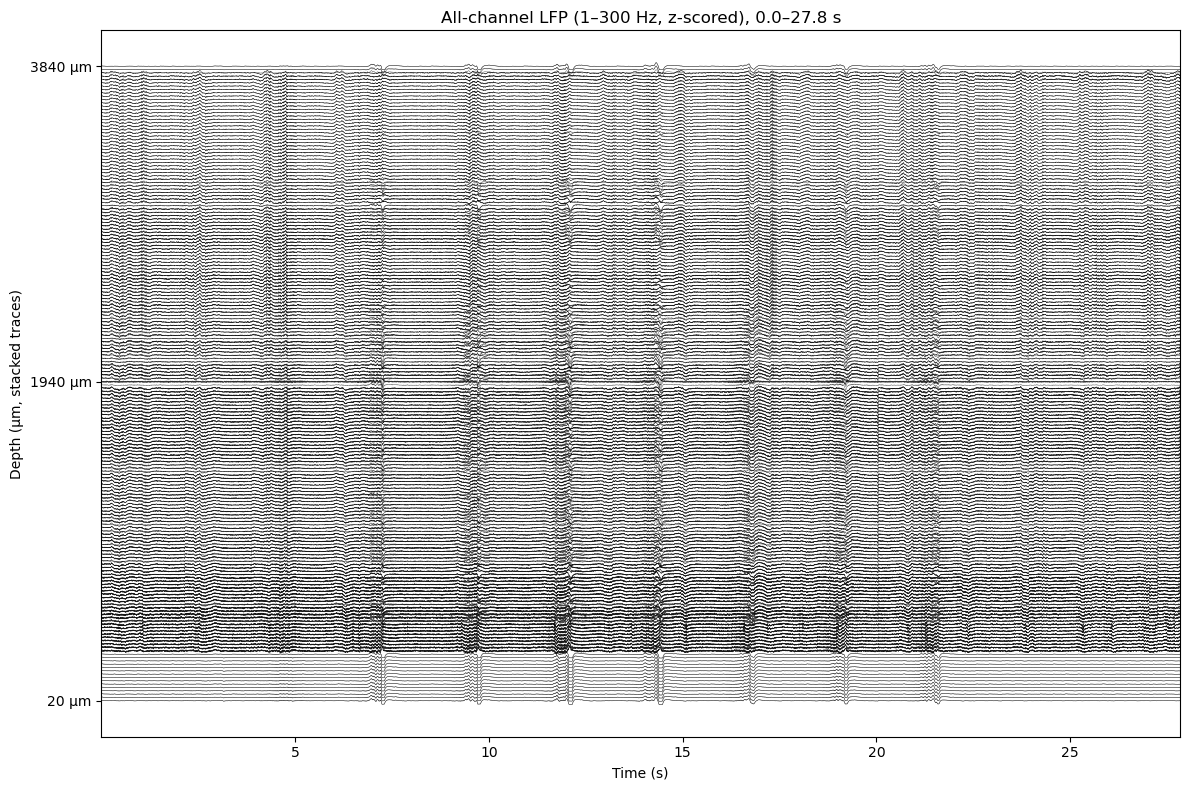

In [20]:
# ---- Get spike zero for clock anchoring ----
spike_times = np.load(phy_dir/'spike_times.npy')
spike_fs = 30000.0
try:
    txt = (phy_dir/'params.py').read_text()
    for line in txt.splitlines():
        if 'sample_rate' in line and '=' in line:
            spike_fs = float(line.split('=')[-1]); break
except Exception:
    pass
spike_zero = float(spike_times.min()/spike_fs)


# ---- Load LFP data directly ----
# Find the LFP continuous.dat file
lfp_file = lfp_dir / 'continuous.dat'
if not lfp_file.exists():
    raise FileNotFoundError(f"LFP file not found: {lfp_file}")


# LFP parameters
fs_lfp = 2500.0     # LFP sampling rate (Hz)
dtype_lfp = np.int16
n_channels = 384    # Neuropixels v1.0


# Calculate time window
if twin is None:
    # Load full file
    total_bytes = lfp_file.stat().st_size
    total_samples = total_bytes // (n_channels * 2)  # int16 = 2 bytes
    samples_start = int(t0 * fs_lfp)
    n_samples = total_samples - samples_start
else:
    t1 = t0 + twin
    samples_start = int(t0 * fs_lfp)
    n_samples = int(twin * fs_lfp)


# Load LFP data via memmap
byte_offset = samples_start * n_channels * np.dtype(dtype_lfp).itemsize
mm_lfp = np.memmap(lfp_file, dtype=dtype_lfp, mode='r', offset=byte_offset)
data_lfp = mm_lfp[:n_samples * n_channels]
lfp = data_lfp.reshape(-1, n_channels).astype('float32')  # shape: (time, channels)


# Create time vector aligned to spike clock
t_lfp = np.arange(lfp.shape[0]) / fs_lfp + t0
# Align to spike zero (LFP starts at same hardware clock as spikes)
t_lfp += spike_zero


# ---- Pick channels and ordering by depth ----
chan_pos = np.load(phy_dir/'channel_positions.npy')  # (n_channels, 2)
depths = chan_pos[:,1]
order = np.argsort(depths)                           # shallow -> deep
if max_ch is not None:
    # subsample channels uniformly by depth if too many
    step = max(1, len(order)//max_ch)
    order = order[::step]


# Select channels in depth order
X = lfp[:, order]
t = t_lfp


# ---- Display band-pass and z-score per channel ----
def bandpass(x, fs, lo=bp_lo, hi=bp_hi, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)


try:
    Xb = bandpass(X, fs_lfp, bp_lo, bp_hi, order=3)
except Exception:
    Xb = X


def zscore2D(M):
    m = np.median(M, axis=0, keepdims=True)
    s = np.std(M, axis=0, keepdims=True)
    s[s==0] = 1.0
    return (M - m) / s

Z = zscore2D(Xb)


# ---- Stack and plot: offset by depth (µm) to make a depth map ----
depths_sel = depths[order]
# normalize depth range to a neat spacing
dmin, dmax = float(np.nanmin(depths_sel)), float(np.nanmax(depths_sel))
depth_norm = (depths_sel - dmin) / max(1.0, (dmax - dmin))
offsets = depth_norm * 10000.0    # vertical span for all channels                   
Y = Z * gain + offsets  # stacked signals


plt.figure(figsize=(12, 8))
plt.plot(t, Y, color='k', linewidth=0.3, alpha=0.7)
plt.xlim(t[0], t[-1])
yticks_pos = [offsets[0], offsets[len(offsets)//2], offsets[-1]]
yticks_lab = [f"{int(depths_sel[0])} µm", f"{int(depths_sel[len(offsets)//2])} µm", f"{int(depths_sel[-1])} µm"]
plt.yticks(yticks_pos, yticks_lab)
plt.xlabel("Time (s)")
plt.ylabel("Depth (µm, stacked traces)")
plt.title(f"All-channel LFP ({bp_lo}–{bp_hi} Hz, z-scored), {t[0]:.1f}–{t[-1]:.1f} s")
plt.tight_layout()


# ---- Save figure to results folder ----
out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)


# Build descriptive filename
filename = f"{SESSION}_{STIM}_allchannel_lfp_{t[-1]:.1f}s.png"
out_path = out_dir / filename


plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"✓ Saved: {out_path}")


plt.show()

In [21]:
chan_pos = np.load(phy_dir/'channel_positions.npy')
print(chan_pos[:16])
print(np.unique(np.diff(np.sort(chan_pos[:,1]))))


[[ 43.  20.]
 [ 11.  20.]
 [ 59.  40.]
 [ 27.  40.]
 [ 43.  60.]
 [ 11.  60.]
 [ 59.  80.]
 [ 27.  80.]
 [ 43. 100.]
 [ 11. 100.]
 [ 59. 120.]
 [ 27. 120.]
 [ 43. 140.]
 [ 11. 140.]
 [ 59. 160.]
 [ 27. 160.]]
[ 0. 20.]
